In [37]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.perfmeasures
%aimport pygenesig.mcp_counter
%aimport pygenesig.tools
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.mcp_counter import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd

import seaborn as sns
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Signature Generation and Validation on GTEx with gini-index. 
In this document, we generate and test the signatures ** on the same dataset **. The final result might therefore not be representative. This document is to demonstrate the ease-of-use of *pygenesig*. 

## Load a dataset
Expression Matrix + Tissue Labels

In [9]:
expr = np.load("../../data/gtex/exprs.npy")
target = np.genfromtxt("../../data/gtex/target.csv", delimiter=",", dtype=str)

## Make Signatures

In [10]:
max_rk = 5
min_gini = .85

In [11]:
sg = MCPSignatureGenerator(expr, target)

In [12]:
signatures = sg.mk_signatures()

/pstore/home/sturmg/projects/gene-set-study/pygenesig/mcp_counter.py:45: RuntimeWarning: invalid value encountered in true_divide
  np.subtract(x_max, x_min)
/pstore/home/sturmg/projects/gene-set-study/pygenesig/mcp_counter.py:45: RuntimeWarning: divide by zero encountered in true_divide
  np.subtract(x_max, x_min)


### store signatures as GMT
first, translate to gene symbols

In [43]:
gene_symbols

array(['DDX11L1', 'WASH7P', 'MIR1302-11', ..., 'MT-TE', 'MT-CYB', 'MT-TT'], 
      dtype='<U22')

In [15]:
gene_symbols = np.genfromtxt("../../data/gtex/gene_symbols.csv", delimiter=",", dtype=str)
gene_symbols = gene_symbols[:, 1]

In [16]:
gene_signatures = {
    tissue: set([gene_symbols[i] for i in genes]) for tissue, genes in signatures.items()
}

In [17]:
write_gmt(gene_signatures, "../../results/gtex_mcp.gmt".format(min_gini, max_rk),
          description="Derived from GTEx dataset with pygenesig. MCP counter method. ".format(min_gini, max_rk))

In [48]:
gene_signatures = load_gmt("../../results/gtex_ngs_0.7_3.gmt")

In [65]:
signatures = {
    tissue: np.where(np.in1d(gene_symbols, genes))[0].tolist() for tissue, genes in gene_signatures.items()
}

In [66]:
signatures

{'Adipose Tissue': [242,
  357,
  405,
  501,
  575,
  609,
  742,
  769,
  788,
  845,
  932,
  1167,
  1400,
  1495,
  1527,
  1573,
  1727,
  1799,
  1826,
  1898,
  1899,
  1900,
  2137,
  2230,
  2265,
  2345,
  2544,
  2546,
  2554,
  2607,
  2676,
  2683,
  3017,
  3208,
  3233,
  3306,
  3361,
  3413,
  3416,
  3417,
  3640,
  3641,
  3642,
  3685,
  3762,
  3764,
  3774,
  3787,
  3823,
  3832,
  3851,
  3866,
  3930,
  3933,
  3934,
  4005,
  4063,
  4265,
  4266,
  4420,
  4593,
  4602,
  4607,
  4664,
  4699,
  4738,
  4739,
  4877,
  4988,
  5288,
  5302,
  5367,
  5377,
  5391,
  5489,
  5603,
  5968,
  6086,
  6141,
  6214,
  6272,
  6354,
  6361,
  6362,
  6392,
  6505,
  6513,
  6690,
  6699,
  6923,
  6998,
  7221,
  7282,
  7291,
  7320,
  7321,
  7337,
  7369,
  7444,
  7602,
  7715,
  7811,
  7812,
  7888,
  7894,
  7895,
  7897,
  7939,
  7960,
  7999,
  8018,
  8028,
  8136,
  8172,
  8222,
  8340,
  8395,
  8398,
  8436,
  8438,
  8439,
  8457,
  8586,
  8660,
 

In [67]:
for name, genes in signatures.items():
    print(name, len(genes))

Thyroid 1728
Blood Vessel 198
Stomach 1333
Small Intestine 2270
Ovary 2049
Heart 1289
Adrenal Gland 1475
Vagina 707
Prostate 912
Salivary Gland 947
Brain 2390
Esophagus 93
Pituitary 2891
Lung 810
Pancreas 665
Adipose Tissue 726
Skin 798
Blood 753
Breast 257
Uterus 347
Liver 1013
Muscle 1823
Spleen 1761
Nerve 2110
Testis 8645
Kidney 1812
Colon 305


## Test Signatures
(You could also load a different dataset, e.g. from a different species here)

In [68]:
st = MCPSignatureTester(expr, target)

In [69]:
actual, predicted = st.test_signatures(signatures)

In [70]:
confmat = st.confusion_matrix(signatures, actual, predicted)

In [71]:
sig_labels = st.sort_signatures(signatures)

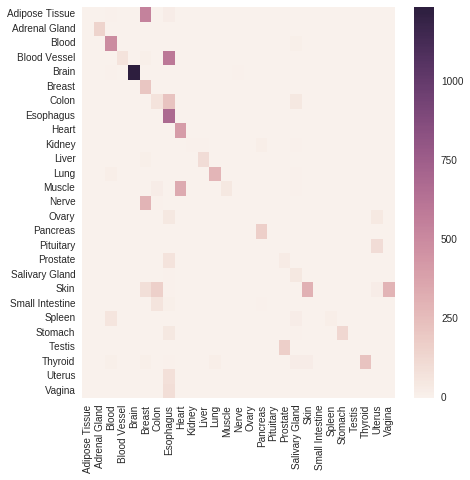

In [72]:
fig, ax = subplots(figsize=(7, 7))
sns.heatmap(confmat, ax=ax, xticklabels=sig_labels, yticklabels=sig_labels)


Binary classifications performance per signatures

In [11]:
print("Tissue", "Sens", "Spec", "MCC")
for i, sig in enumerate(sig_labels):
    TP = confmat[i, i]
    FN = np.sum(confmat[i, :]) - TP
    FP = np.sum(confmat[:, i]) - TP
    TN = np.sum(confmat) - TP - FN - FP
    m = (TP, FN, FP, TN)
    print(sig, pm.sens(*m), pm.spec(*m), pm.mcc(*m))

Tissue Sens Spec MCC
Adipose Tissue 0.649913344887 0.984146955209 0.689080668795
Adrenal Gland 1.0 1.0 1.0
Blood 0.919765166341 0.965061143 0.746200445951
Blood Vessel 0.882438316401 0.99821337417 0.923372479993
Brain 1.0 0.999587118084 0.99860448652
Breast 0.289719626168 1.0 0.533400512698
Colon 0.565217391304 0.997310513447 0.706730730413
Esophagus 0.52332361516 0.988391376451 0.635968464244
Heart 1.0 0.997904597559 0.978958933014
Kidney 1.0 1.0 1.0
Liver 1.0 0.999881037354 0.995765381692
Lung 0.984375 1.0 0.991854577262
Muscle 1.0 0.995799876467 0.960641338935
Nerve 1.0 0.998418683858 0.978506039359
Ovary 1.0 0.999881347888 0.994825852595
Pancreas 1.0 0.999880296864 0.997029106558
Pituitary 1.0 1.0 1.0
Prostate 0.905660377358 1.0 0.951097218837
Salivary Gland 0.929824561404 0.99196976854 0.635853186811
Skin 0.82808988764 0.999607072692 0.89907639506
Small Intestine 0.954545454545 0.982576745289 0.584355330538
Spleen 1.0 0.992281201758 0.781431113853
Stomach 0.765625 0.9997599904 0.8